In [1]:
from sklearn.naive_bayes import GaussianNB
import pandas as pd
from sklearn.metrics import roc_auc_score, roc_curve
import time
from matplotlib import pyplot as plt
import numpy as np
import pickle

In [2]:
df_train = pd.read_csv('train_splitted.csv')
df_valid = pd.read_csv('valid_splitted.csv')

X_train = df_train.drop(columns=['ID_code', 'target'])
X_valid = df_valid.drop(columns=['ID_code', 'target'])

y_train = df_train['target']
y_valid = df_valid['target']

In [3]:
N_1_t = len(X_train[y_train==1]) #/len(X_valid)
N_0_t = len(X_train[y_train==0]) #/len(X_valid)
print(N_1_t, N_0_t)

16046 143954


In [4]:
P_1 = N_1_t/len(X_train)
P_0 = N_0_t/len(X_train)

print(P_1, P_0)

0.1002875 0.8997125


## Que particularidad tiene el dataset?

Sería un buen modelo uno que predice con un Accuracy de 0.9?

# Bayes rule

Target = 1  
$\large p(t=1|V_0, V_1, ..., V_{199}) = \frac{p(V_0, V_1, ..., V_{199}|t=1)P(t=1)}{p(V_0,V_1, ..., V_{199})} \quad$

Target = 0  
$\large p(t=0|V_0, V_1, ..., V_{199}) = \frac{p(V_0, V_1, ..., V_{199}|t=0)P(t=0)}{p(V_0,V_1, ..., V_{199})} \quad$

# Naive Bayes

$\large \large p(t=1|V_0, V_1, ..., V_{199}) = \frac{p(V_0|t=1) p(V_1|t=1) ... p(V_{199}|t=1) P(t=1)}{p(V_0,...,V_{199})} \quad$ Independence of Conditionals

$\large \large p(t=0|V_0, V_1, ..., V_{199}) = \frac{p(V_0|t=0) p(V_1|t=0) ... p(V_{199}|t=0) P(t=0)}{p(V_0,...,V_{199})} \quad$ Independence of Conditionals

# Create a train model

https://scikit-learn.org/stable/modules/generated/sklearn.naive_bayes.GaussianNB.html#sklearn.naive_bayes.GaussianNB

In [5]:
clf = GaussianNB()
%time clf.fit(X_train.values, y_train.values)

CPU times: user 1.93 s, sys: 222 ms, total: 2.15 s
Wall time: 425 ms


GaussianNB(priors=None, var_smoothing=1e-09)

In [6]:
clf.classes_

array([0, 1])

In [77]:
clf.class_prior_

array([0.89951, 0.10049])

Que son sigma y theta y por que tienen esas dimensiones?

In [81]:
clf.sigma_.shape, clf.theta_.shape

((2, 200), (2, 200))

# Evaluate Train dataset

In [8]:
print('Accuracy:', clf.score(X_train, y_train))
predicted_proba_tr = clf.predict_proba(X_train)
predicted_class_tr = clf.predict(X_train)
print('AUC_ROC:', roc_auc_score(y_train, predicted_proba_tr[:,1]))
print('AUC_ROC (CLASSES): (No es correcto)', roc_auc_score(y_train, predicted_class_tr))

Accuracy: 0.92193125
AUC_ROC: 0.8893228519335807
AUC_ROC (CLASSES): (No es correcto) 0.6757845397526141


https://towardsdatascience.com/understanding-auc-roc-curve-68b2303cc9c5

$ TPR = \frac{TP}{TP+FN}$

$ FPR = \frac{FP}{TP+FN}$

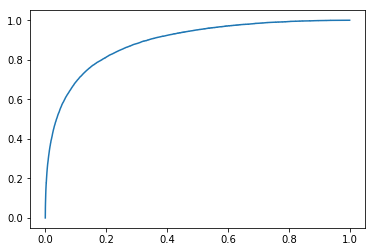

In [9]:
fpr, tpr, thres = roc_curve(y_train, predicted_proba_tr[:,1])
plt.plot(fpr, tpr)
plt.show()

In [10]:
# Descomentar y graficar
# fpr, tpr, thres = roc_curve(y_train, predicted_class_tr)
# len(thres)
# plt.plot(fpr, tpr)
# plt.show()

In [11]:
pickle.dump(clf, open('naive_bayes_train_only.pk', 'wb'))

# Validation dataset

In [12]:
print('Accuracy:', clf.score(X_valid, y_valid))
predicted_proba_val = clf.predict_proba(X_valid)
predicted_class_val = clf.predict(X_valid)
print('AUC_ROC:', roc_auc_score(y_valid, predicted_proba_val[:,1]))
print('AUC_ROC (CLASSES): (No es correcto)', roc_auc_score(y_valid, predicted_class_val))

Accuracy: 0.921025
AUC_ROC: 0.8921595960535734
AUC_ROC (CLASSES): (No es correcto) 0.6728189896099785


In [13]:
fpr, tpr, thres = roc_curve(y_valid, predicted_proba_val[:,1])

In [14]:
print(thres)

[1.99928535e+00 9.99285350e-01 9.68381076e-01 ... 6.92799419e-04
 6.92674617e-04 6.28074097e-05]


FPr: Numero de 0s clasificados mal sobre el total de 0s (Dije que era positivo cuando en realidad era negativo)

TPr: Numero de 1s clasificados bien sobre el total de 1s (Dije que era positivo cuando era positivo)

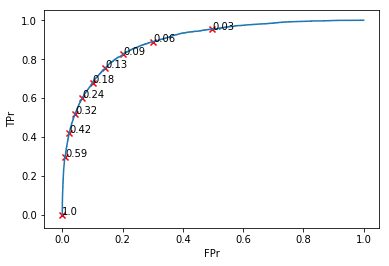

In [15]:
plt.plot(fpr, tpr)

for i, th in enumerate(thres[1:]):
    if i%500==0:
        plt.scatter(fpr[i], tpr[i], marker='x', c='r')
        plt.text(fpr[i], tpr[i], np.round(th,2))
plt.xlabel('FPr')
plt.ylabel('TPr')
plt.show()

Pongo umbral en 0; siempre estimo un 1, es decir que voy a tener 100% TP

Ejemplo:
- pongo umbral en 0.5
- Tengo muy pocos FP y tengo en el orden de 0.4 TP.
- Como esta muy desbalanceado y hay muchos mas negativos, el accuracy da 'alto' para este umbral

In [16]:
idx_50 = np.where((thres > 0.4999) & (thres<0.5001))[0][0]
print(tpr[idx_50], fpr[idx_50])

0.36204343534057254 0.01591187270501836


In [17]:
# Cantidad de Positivos
N_1 = len(X_valid[y_valid==1])
# Cantidad de Negativos
N_0 = len(X_valid[y_valid==0])
print(N_1, N_0)

4052 35948


In [18]:
FP = fpr[idx_50]*N_0
TP = tpr[idx_50]*N_1

In [19]:
Correct_predicts = N_0-FP + TP
print(Correct_predicts)

36843.0


In [20]:
Correct_predicts/len(X_valid)

0.921075

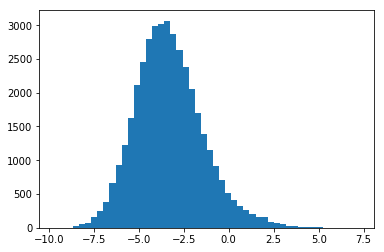

In [21]:
log_odds = np.log(predicted_proba_val[:,1]/(1-predicted_proba_val[:,1]))
_ = plt.hist(log_odds, 50)

# Cantidad de parámetros del modelo

In [22]:
print(clf.sigma_.shape, clf.theta_.shape)
params = np.prod(clf.sigma_.shape), np.prod(clf.theta_.shape)
print(params)
sum(params)

(2, 200) (2, 200)
(400, 400)


800

# Busqueda de hiperparamtros

In [23]:
variances = np.logspace(-11, -9, 20)

In [24]:
auc_rocs=[]
for v in variances:
    clf = GaussianNB(var_smoothing=v)
    clf.fit(X_train.values, y_train.values)
    predicted_proba = clf.predict_proba(X_valid)
    sc = roc_auc_score(y_valid, predicted_proba[:,1])
    auc_rocs.append(sc)
    print(sc)

0.8921608523928003
0.8921608798537671
0.8921609141799756
0.8921609828323921
0.892160989697634
0.8921610377543256
0.8921610034281173
0.8921608455275586
0.8921608729885253
0.8921610446195672
0.8921610034281172
0.892161030889084
0.8921609965628755
0.8921611270024674
0.8921610583500507
0.8921609828323922
0.8921608592580419
0.8921606395703084
0.8921603237691913
0.8921595960535734


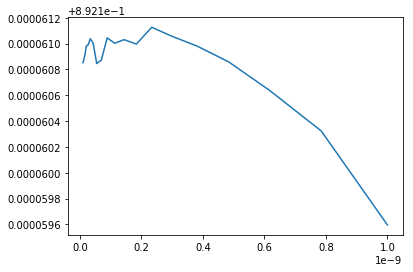

In [25]:
plt.plot(variances, auc_rocs)

# Modelo entrenado con toda la data

In [65]:
df = pd.read_csv('train.csv')

In [66]:
X_train = df.drop(columns=['ID_code', 'target'])
y_train = df['target']

In [67]:
X_train.shape

(200000, 200)

In [68]:
clf = GaussianNB()
%time clf.fit(X_train.values, y_train.values)

CPU times: user 2.12 s, sys: 244 ms, total: 2.36 s
Wall time: 491 ms


GaussianNB(priors=None, var_smoothing=1e-09)

In [69]:
pickle.dump(clf, open('naive_bayes_all_data.pk', 'wb'))

In [70]:
X_test = pd.read_csv('test.csv').set_index('ID_code')

In [71]:
predicted_proba_test = clf.predict_proba(X_test)

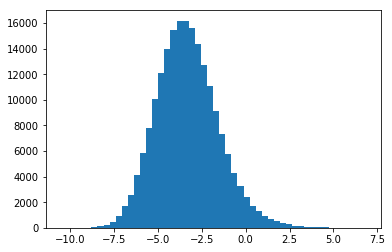

In [72]:
predicted_test = predicted_proba_test[:,1]
log_odds = np.log(predicted_test/(1-predicted_test))
_ = plt.hist(log_odds, 50)

In [74]:
X_test['target'] = predicted_test

In [76]:
filename = 'submission_naive_bayes_{}.csv'.format(int(time.time()))
message = 'naive bayes third submission'
X_test[['target']].to_csv(filename)

In [33]:
# ! kaggle competitions submit -c santander-customer-transaction-prediction -f {filename} -m '{message}'

100%|███████████████████████████████████████| 6.07M/6.07M [00:22<00:00, 278kB/s]
Successfully submitted to Santander Customer Transaction Prediction